**Problem 3.1**

**a)** First we import the usual modules.

In [2]:
# The workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.special

# Plotting modules
import matplotlib.pyplot as plt

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Seaborn makes plots look nice
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
sns.set_style('darkgrid', {'axes.facecolor': '(0.875, 0.875, 0.9)'})

Next, we read in the two datasets as Pandas `DataFrames`. 

In [8]:
# Read in the dataset
AerobicIntensity = pd.read_csv("data/20151001_aerobic_mean_intensities.csv",comment="#")
AnaerobicIntensity = pd.read_csv("data/20151001_anaerobic_mean_intensities.csv", comment="#")

AerobicIntensity.head()

,0 plasmids/cell,10^1 plasmids/cell,10^2 plasmids/cell,10^3 plasmids/cell,10^4 plasmids/cell,10^5 plasmids/cell
0,107.737249,105.097792,106.845238,104.485356,169.438242,111.046339
1,109.843794,102.075567,106.576923,104.136622,117.837283,215.607085
2,107.533228,102.937931,106.522358,105.623410,150.432234,115.541296
3,107.875289,103.765487,106.480663,104.078212,115.597059,141.717617
4,109.094017,105.121118,104.895810,102.788732,132.905286,107.345992


In [9]:
AnaerobicIntensity.head()

,0 plasmids/cell,10^1 plasmids/cell,10^2 plasmids/cell,10^3 plasmids/cell,10^4 plasmids/cell,10^5 plasmids/cell
0,105.212500,104.238739,103.066667,102.989024,112.567732,108.008909
1,104.511254,103.918619,103.363229,103.045845,103.782544,104.361919
2,106.051625,103.953608,102.555035,103.908479,104.415214,104.712895
3,103.634241,103.371528,102.973529,103.535368,101.867410,177.966820
4,104.882897,104.415459,103.840746,103.622363,159.855365,104.092664


The data are not tidy. To make tidying easier, we rename the columns to plain numerical values before melting the `DataFrames`.

In [7]:
# Change column names to make melting easier
AerobicIntensity.columns = ["0", "1e1", "1e2", "1e3", "1e4", "1e5"]
AnaerobicIntensity.columns = ["0", "1e1", "1e2", "1e3", "1e4", "1e5"]

# Melt untidy data to create tidy dataframes
CleanAerobic = pd.melt(AerobicIntensity, var_name="PlasmidsPerCell", value_name= "MeanPixel").dropna()
CleanAnaerobic = pd.melt(AnaerobicIntensity, var_name="PlasmidsPerCell", value_name= "MeanPixel").dropna()

CleanAerobic.head()

,PlasmidsPerCell,MeanPixel
0,0,107.737249
1,0,109.843794
2,0,107.533228
3,0,107.875289
4,0,109.094017


In [6]:
CleanAnaerobic.head()

,PlasmidsPerCell,MeanPixel
0,0,105.212500
1,0,104.511254
2,0,106.051625
3,0,103.634241
4,0,104.882897


We are asked to compute the number of of transformed cells, which requires us to decide on a criterion for what constitutes a transformed cell. Our first thought was to plot a histogram of the the mean pixel values to see if there were two clear peaks in frequency, in which case we would have set our cutoff for transformed vs. non-transformed somewhere in between the two peaks. We chose a large number of bins in order to increase the chance of seeing distinct peaks.

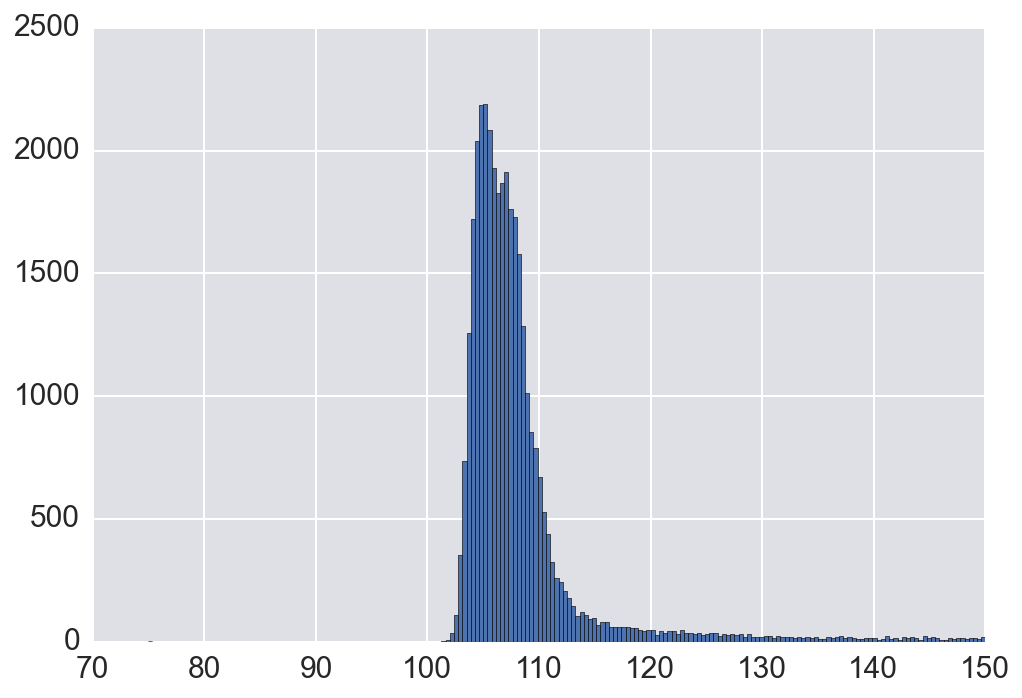

In [15]:
# Plot a histogram of the mean pixel values for the aerobic dataset 
_ = plt.hist(CleanAerobic["MeanPixel"],bins=200, range=[75,150]) 

It doesn't look like there are two distinct peaks, probably because overall there are so many more untransformed cells than transformed cells. So we came up with an alternative: find the maximum mean pixel value under the zero plasmids/cell condition, since we know for sure that none of those cells could have been transformed. We will round up to the nearest integer from that maximum and call that our cutoff for transformed vs. non-transformed cells. We note that this metric is not immune to false positives: it is possible that the cells in the zero plasmids/cell condition in this dataset do not encompass the full range of possible mean pixel values for non-transformed cells. However, although we could reduce the number of false positives by setting our cutoff at some arbitrary higher value, we prefer a greater risk of false positives as compared to false negatives. 

In [19]:
np.max(CleanAerobic[CleanAerobic["PlasmidsPerCell"]=="0"].MeanPixel)

111.99305555555556

In [22]:
np.max(CleanAnaerobic[CleanAnaerobic["PlasmidsPerCell"]=="0"].MeanPixel)

109.59493670886076

We got two different maximum values for the two datasets. For the sake of consistency, we will take the higher of the two values and use it as our cutoff for both. So we define transformed cells as all cells with MeanPixel $\geq$ 112.0.

Now we need to compute the number of transformed cells in each dataset.

In [35]:
# Create new DataFrames containing only transformed cells, i.e. cells above our mean pixel value cutoff
TransformedCellsAerobic = CleanAerobic[CleanAerobic["MeanPixel"] > 112.0]
TransformedCellsAnaerobic = CleanAnaerobic[CleanAnaerobic["MeanPixel"] > 112.0]

# We want to count the number of transformed cells, and we'll also go ahead and count the number of total cells 
# since we will need this value later to determine the probability of transformation
NtAerobic = TransformedCellsAerobic['MeanPixel'].count()
NAerobic = CleanAerobic['MeanPixel'].count()

NtAnaerobic = TransformedCellsAnaerobic['MeanPixel'].count()
NAnaerobic = CleanAnaerobic['MeanPixel'].count()

print('Number of transformed cells in Aerobic dataset: ' + str(NtAerobic))
print('Number of total cells in Aerobic dataset: ' + str(NAerobic))
print('Number of transformed cells in Anaerobic dataset: ' + str(NtAnaerobic))
print('Number of total cells in Anaerobic: ' + str(NAnaerobic))

Number of transformed cells in Aerobic dataset: 7314
Number of total cells in Aerobic dataset: 38963
Number of transformed cells in Anaerobic dataset: 1925
Number of total cells in Anaerobic: 27876


**b)** Now that we have defined our parameters, we can plot our posterior. For our posterior distribution, we chose the binomial distribution as our likelihood since 1) we are dealing with Boolean data (either cell is transformed or it is not) and 2) we are interested in the probability of getting a certain number of successes (transformations) out of a given number of trials. Likelihood:
\begin{align}
P(n_t \mid n,p,I) = \frac{n!}{n_t!(n - n_t)!}p^{n_t}(1 - p)^{n - n_t}
\end{align}

For the prior, we assumed we do not know anything about the probability $p$ of transformation of a given cell, so we assume a uniform prior for $p$ between 0 and 1. Prior:
\begin{align}
P(p \mid n,I) = \left\{
\begin{array}{cl}
1 & 0 \leq p \leq 1\\
0 & \mathrm{otherwise}
\end{array}
\right.
\end{align}

For our normalization constant $P(n_t \mid n, I)$, we recalled that there are $n + 1$ possible numbers of transformants from $n$ cells (because there could be zero transformants). Since we assumed no prior knowledge, all possible numbers of transformants should be equally likely, so $P(n_t \mid n, I) = \frac{1}{n \, + \, 1}$.

With the likelihood, prior, and normalization constant as defined above, our posterior distribution is:

\begin{align}
P(p \mid n_t,n,I) = \left\{
\begin{array}{cl}
\frac{(n \, + \, 1)!}{n_t!(n \, - \, n_t)!}p^{n_t}(1 - p)^{n - n_t} & 0 \leq p \leq 1\\
0 & \mathrm{otherwise}
\end{array}
\right.
\end{align}

We needed to define a Python function for our posterior. We could use the `scipy.misc.comb` function to combute the cominbation, but we recieved the following error:
`OverflowError: int too large to conver to float`

In [22]:
# Our posterior distribution is (n + 1)!/(n! * (n - nt)!) * p**(nt) * (1 - p)**(n-nt)
# At first we thought of using the scipy.misc.comb to compute the combination, but we recieve the overflow error:
# 'OverflowError: int too large to convert to float'
def posterior(nt, n, p):
    '''
    The Posterior
    '''
    return scipy.misc.comb(n, nt, exact = True) * (n + 1) * p**(nt) * (1-p)**(n - nt)

We switched to defining the log of our posterior instead. We used the `scipy.special.gammaln` function to deal with the factorials in our posterior. **put in latex for what gamma is**

In [ ]:
# Let's compute the log of the posterior
# We can use a scipy.special function to deal with the factorials

def log_posterior(nt, n, p):
    '''
    Log of posterior for Boolean data.
    '''
    return scipy.special.gammaln(n + 2) - scipy.special.gammaln(nt +1) - scipy.special.gammaln(n - nt +1) \
           + nt * np.log(p) + (n - nt) * np.log(1 - p)   

Now we can plot the posteriors of our aerobic and anaerobic data sets. Since we defined a the log of our posterior we can plot our posteriors by taking the exponential of the `log_posterior`. 

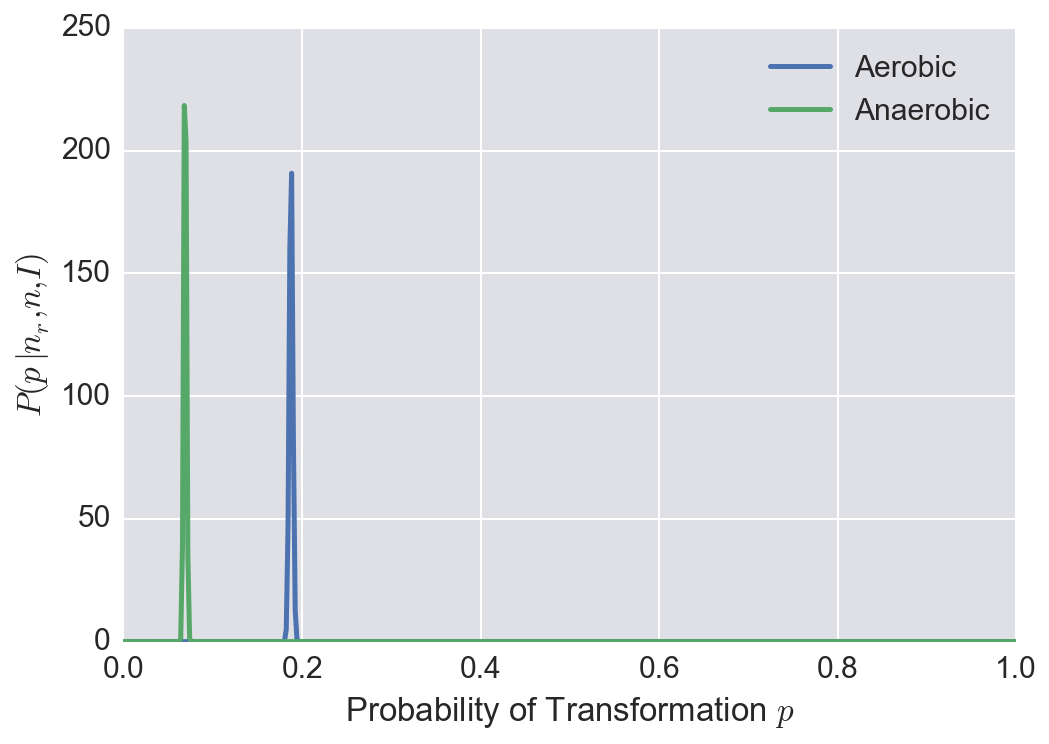

In [23]:
# let's create an set of evenly spaced numbers for p
# Our maximum probability is 1 and minium probability is 0, so we set our interval
p = np.linspace (0, 1, 500)

# Now we can plot our posteriors for both the aerobic and anaerobic data sets
# We were working with the log of our posteriors because the int value of our posterior was too big for python to handle
# To plot our posteriors, we can simply take the exponential 
plt.plot(p, np.exp(log_posterior(NtAerobic, NAerobic, p)), '-')
plt.plot(p, np.exp(log_posterior(NtAnaerobic, NAnaerobic, p)), '-')

plt.legend(('Aerobic', 'Anaerobic'), loc = 'upper right')
plt.xlabel('Probability of Transformation $p$')
plt.ylabel(r'$P(p\mid n_r, n, I)$')

We thought it would be best to zoom into our plots in order to see more about the peaks, but thought that the plot with the entire probability from one to zero. We can do this by setting x axis limits.

(0, 0.3)

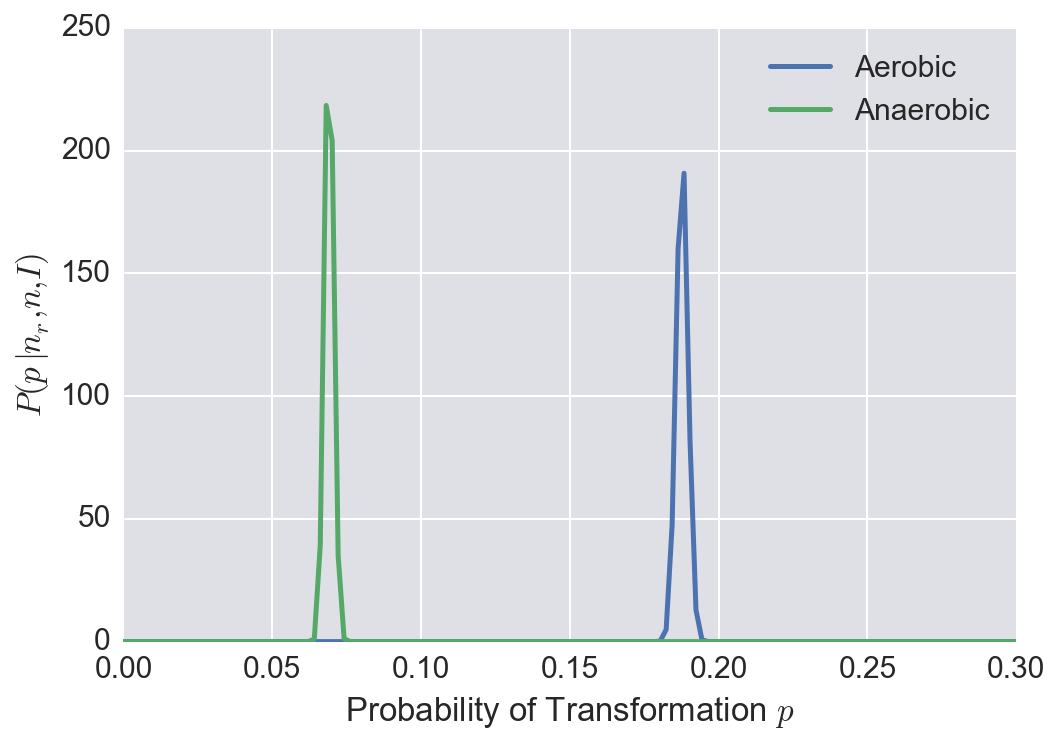

In [25]:
# We want to zoom in on our graph so we are going to set a limit to our x axis.
plt.plot(p, np.exp(log_posterior(NtAerobic, NAerobic, p)), '-')
plt.plot(p, np.exp(log_posterior(NtAnaerobic, NAnaerobic, p)), '-')

plt.legend(('Aerobic', 'Anaerobic'), loc = 'upper right')
plt.xlabel('Probability of Transformation $p$')
plt.ylabel(r'$P(p\mid n_r, n, I)$')
plt.xlim(0, 0.3)

**Part c:**

Derivation in Shashank's notebook.

**Question 2:**

Why Gaussian?

Since the cells that are expressing the reporter construct are a sample from all the cells that are present in the embryo, it is fair to assume that the expression levels are Gaussian distributed (central limit theorem).
As far as the background goes, they are relying on the expression of a reporter construct that can be variably expressed (comment on mosaicism in early drosophila embryos).
Hence Gaussian +noise.